In [1]:
import re
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from imblearn.metrics import classification_report_imbalanced

warnings.filterwarnings('ignore')

In [2]:
cardio = pd.read_csv('cardio_cleaned.csv')
cardio.head()

random_seed = 1361

In [3]:
cardio.drop(['smoking_no'], axis = 1, inplace = True)

In [4]:
data = cardio.rename(columns={ "smoking_yes": "smoking"})

In [5]:
data.head()

,age,height,weight,systolic_bp,diastolic_bp,target,gender_female,gender_male,cholesterol_high,cholesterol_normal,cholesterol_very_high,glucose_high,glucose_normal,glucose_very_high,smoking,alcohol_intake_no,alcohol_intake_yes,physical_activity_no,physical_activity_yes
0,50,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0,1,0,0,1
1,55,156,85.0,140,90,1,1,0,0,0,1,0,1,0,0,1,0,0,1
2,51,165,64.0,130,70,1,1,0,0,0,1,0,1,0,0,1,0,1,0
3,48,169,82.0,150,100,1,0,1,0,1,0,0,1,0,0,1,0,0,1
4,47,156,56.0,100,60,0,1,0,0,1,0,0,1,0,0,1,0,1,0


In [6]:
#Chech for class imbalance
print(data.smoking.value_counts())

0    54992
1     5150
Name: smoking, dtype: int64


In [7]:
y = data['smoking']
X = data.drop(labels = ['smoking', 'target'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_seed, stratify = y)

**Baseline evaluation without handling class imbalance**

---






In [8]:
clf_names = ['Decision Tree', 'LogisticRegression', 'XGBoost']
classifiers = [DecisionTreeClassifier(criterion = 'entropy', max_depth = 15,  random_state = random_seed), 
               LogisticRegression(solver = 'saga', max_iter = 1000, random_state = random_seed),
               xgb.XGBClassifier(random_state = random_seed, verbosity = 0)]

In [9]:
baseline_results = []

for name, clf in zip(clf_names, classifiers):
    print(f"Classifier: {name}\n")
    pipeline = make_pipeline(clf)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report_imbalanced(y_test, y_pred, target_names = ["Smoker", "Non-smoker"])
    print(report)
    bal_acc = float(report.strip("").split('\n')[5].split('     ')[6].strip())
    baseline_results.append(bal_acc)
    
    conf_matrix = confusion_matrix(y_test, y_pred).T 
    print(conf_matrix)
    print(f"\nFalse Positives: {conf_matrix[0][1]}")
    print("---------------------------------------------------------\n")



Classifier: Decision Tree

                   pre       rec       spe        f1       geo       iba       sup

     Smoker       0.93      0.97      0.23      0.95      0.48      0.24     13748
 Non-smoker       0.41      0.23      0.97      0.30      0.48      0.21      1288

avg / total       0.89      0.91      0.30      0.89      0.48      0.24     15036

[[13314   986]
 [  434   302]]

False Positives: 986
---------------------------------------------------------

Classifier: LogisticRegression

                   pre       rec       spe        f1       geo       iba       sup

     Smoker       0.94      0.99      0.28      0.96      0.52      0.29     13748
 Non-smoker       0.66      0.28      0.99      0.39      0.52      0.25      1288

avg / total       0.91      0.93      0.34      0.91      0.52      0.29     15036

[[13568   931]
 [  180   357]]

False Positives: 931
---------------------------------------------------------

Classifier: XGBoost

                   pre    

**SMOTE**

In [10]:
smote_results = []

for name, clf in zip(clf_names, classifiers):
    print(f"Classifier: {name} with SMOTE\n")
    pipeline = make_pipeline(SMOTE(n_jobs = -1, random_state = random_seed, k_neighbors = 3), clf)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report_imbalanced(y_test, y_pred, target_names = ["Smoker", "Non-smoker"])
    print(report)
    bal_acc = float(report.strip("").split('\n')[5].split('     ')[6].strip())
    smote_results.append(bal_acc)
    
    conf_matrix = confusion_matrix(y_test, y_pred).T 
    print(conf_matrix)
    print(f"\nFalse Positives: {conf_matrix[0][1]}")
    print("---------------------------------------------------------\n")

Classifier: Decision Tree with SMOTE

                   pre       rec       spe        f1       geo       iba       sup

     Smoker       0.94      0.89      0.44      0.91      0.62      0.40     13748
 Non-smoker       0.27      0.44      0.89      0.33      0.62      0.37      1288

avg / total       0.89      0.85      0.48      0.86      0.62      0.40     15036

[[12190   725]
 [ 1558   563]]

False Positives: 725
---------------------------------------------------------

Classifier: LogisticRegression with SMOTE

                   pre       rec       spe        f1       geo       iba       sup

     Smoker       0.95      0.88      0.50      0.91      0.66      0.46     13748
 Non-smoker       0.28      0.50      0.88      0.36      0.66      0.42      1288

avg / total       0.89      0.85      0.53      0.86      0.66      0.45     15036

[[12073   644]
 [ 1675   644]]

False Positives: 644
---------------------------------------------------------

Classifier: XGBoost with 

**NearMiss3**

In [11]:
nearmiss_results = []

for name, clf in zip(clf_names, classifiers):
    print(f"Classifier: {name} with NearMiss v3\n")
    pipeline = make_pipeline(NearMiss(version = 3, n_jobs = -1, n_neighbors_ver3 = 3), clf)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report_imbalanced(y_test, y_pred, target_names = ["Smoker", "Non-smoker"])
    print(report)
    bal_acc = float(report.strip("").split('\n')[5].split('     ')[6].strip())
    nearmiss_results.append(bal_acc)
    
    conf_matrix = confusion_matrix(y_test, y_pred).T 
    print(conf_matrix)
    print(f"\nFalse Positives: {conf_matrix[0][1]}")
    print("---------------------------------------------------------\n")

Classifier: Decision Tree with NearMiss v3

                   pre       rec       spe        f1       geo       iba       sup

     Smoker       0.95      0.51      0.72      0.66      0.61      0.36     13748
 Non-smoker       0.12      0.72      0.51      0.21      0.61      0.37      1288

avg / total       0.88      0.53      0.70      0.63      0.61      0.36     15036

[[7026  364]
 [6722  924]]

False Positives: 364
---------------------------------------------------------

Classifier: LogisticRegression with NearMiss v3

                   pre       rec       spe        f1       geo       iba       sup

     Smoker       0.98      0.71      0.84      0.82      0.77      0.59     13748
 Non-smoker       0.21      0.84      0.71      0.34      0.77      0.60      1288

avg / total       0.91      0.72      0.83      0.78      0.77      0.59     15036

[[9742  209]
 [4006 1079]]

False Positives: 209
---------------------------------------------------------

Classifier: XGBoost w

**CostSensitiveLearning**

In [12]:
cost_matrix = [[0, 54992], [5150, 0]]
cost_sens_results = []

def predict(prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(np.float)
    
    return y_pred

for name, clf in zip(clf_names, classifiers):
    print(f"Classifier: {name} with isotonic calibration\n")
    cc = CalibratedClassifierCV(clf, method="isotonic", cv=2)
    model = cc.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    y_pred = predict(y_prob, cost_matrix)
    report = classification_report_imbalanced(y_test, y_pred, target_names = ["Smoker", "Non-smoker"])
    print(report)
    bal_acc = float(report.strip("").split('\n')[5].split('     ')[6].strip())
    cost_sens_results.append(bal_acc)

    conf_matrix = confusion_matrix(y_test, y_pred).T 
    print(conf_matrix) 
    print(f"\nFalse Positives: {conf_matrix[0][1]}")
    print("---------------------------------------------------------\n")

Classifier: Decision Tree with isotonic calibration

                   pre       rec       spe        f1       geo       iba       sup

     Smoker       0.97      0.73      0.74      0.83      0.74      0.54     13748
 Non-smoker       0.20      0.74      0.73      0.32      0.74      0.54      1288

avg / total       0.90      0.73      0.74      0.79      0.74      0.54     15036

[[10043   335]
 [ 3705   953]]

False Positives: 335
---------------------------------------------------------

Classifier: LogisticRegression with isotonic calibration

                   pre       rec       spe        f1       geo       iba       sup

     Smoker       0.99      0.69      0.89      0.81      0.78      0.60     13748
 Non-smoker       0.21      0.89      0.69      0.34      0.78      0.62      1288

avg / total       0.92      0.71      0.87      0.77      0.78      0.60     15036

[[9470  144]
 [4278 1144]]

False Positives: 144
---------------------------------------------------------


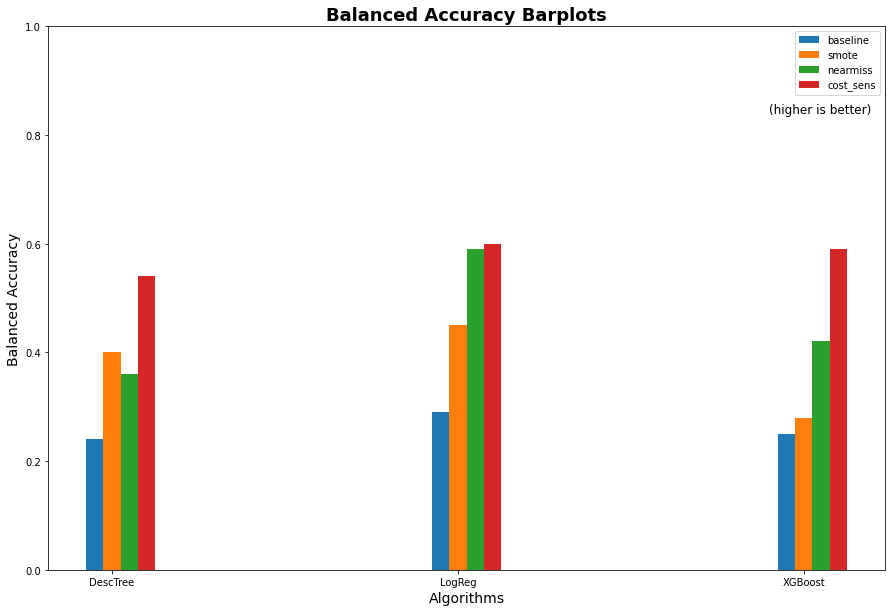

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))
N = 3
ind = np.arange(N) 
width = 0.05
  
bar1 = plt.bar(ind, baseline_results, width)
bar2 = plt.bar(ind+width, smote_results, width)
bar3 = plt.bar(ind+width*2, nearmiss_results, width)
bar4 = plt.bar(ind+width*3, cost_sens_results, width)
  
ax.set_title('Balanced Accuracy Barplots', fontsize=18, fontweight='bold')    
plt.xlabel("Algorithms", fontsize=14)
plt.ylabel('Balanced Accuracy',fontsize=14)
ax.text(1.95,0.84, '(higher is better)', fontsize=12,  color='black')
  
plt.ylim((0,1))   
plt.xticks(ind+width,['DescTree', 'LogReg', 'XGBoost'])
plt.legend((bar1, bar2, bar3, bar4),('baseline', 'smote', 'nearmiss', 'cost_sens'))
plt.show()